In [ ]:
from  transformers import Wav2Vec2Model, Wav2Vec2Processor
import torch 
import librosa 

In [ ]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [5]:
def extract_wav2vec_features(audio_path):
    signal,sr = librosa.load(audio_path,sr=16000)
    inputs = processor(signal,return_tensors="pt", sampling_rate=16000)

    with torch.no_grad():
        outputs = model(**inputs)
    
    embedding = torch.mean(outputs.last_hidden_state, dim=1)
    return embedding.squeeze()

In [6]:
import torch.nn.functional as F

def compare_embeddings(emb1, emb2):
    similarity = F.cosine_similarity(emb1, emb2, dim=0).item()
    return similarity

In [7]:
def compare_voices(path1, path2):
    emb1  =extract_wav2vec_features(path1)
    emb2  =extract_wav2vec_features(path2)
    similarity = compare_embeddings(emb1, emb2)
    return similarity

In [14]:
def get_pitch_curve(path,sr=22050 , fmin=80.0 , fmax=10000.0):
    y,_ = librosa.load(path,sr=sr)

    pitches = librosa.yin(y, sr=sr, fmin=fmin, fmax=fmax)
    times  = librosa.times_like(pitches, sr=sr)
    return pitches, times

In [15]:
def plot_pitch_curve(ref_path, user_path):
    ref_pitches, ref_times = get_pitch_curve(ref_path)
    user_pitches, user_times = get_pitch_curve(user_path)

    plt.figure(figsize=(10, 4))
    plt.plot(ref_times, ref_pitches, label='Reference Pitch Curve')
    plt.plot(user_times, user_pitches, label='User Pitch Curve')
    plt.xlabel('Time (s)')
    plt.ylabel('Pitch (Hz)')
    plt.title('Pitch Curve Over Time')
    plt.legend()
    plt.grid()
    plt.show()

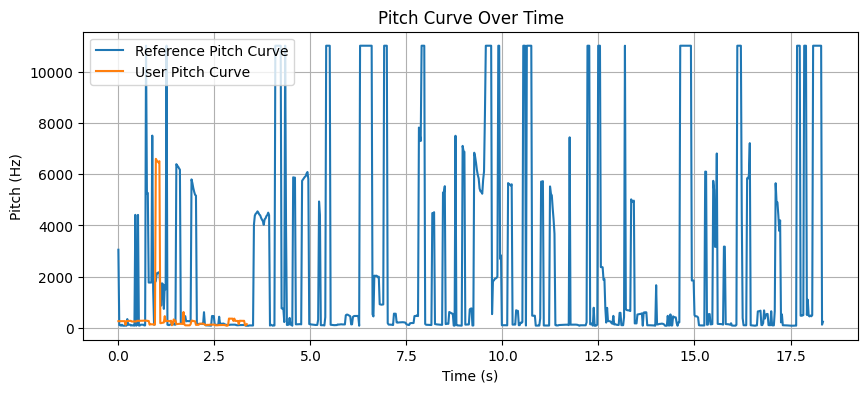

In [16]:
plot_pitch_curve("./data/harvard.wav", "./data/jackhammer.wav")